# ML Models: Distinguishing Claims from Opinions

### Background and Objective 

A social media company has sought a machine learning model capable of distinguishing between videos that present claims and those expressing opinions. An effective prediction model could streamline the handling of user reports, reducing backlog and enabling more efficient prioritization.



### Methodology 

1. Data explarotion and trasformation 
2. Modeling workflow
3. Model selection process


### Data explarotion

The firt step in any project is to undestand what type of data we have avalible and the quality of the data for this project the only data provided by the client 

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Import the csv data in a pandas dataframe and display the first 5 observations
data=pd.read_csv(r"C:\Users\sergi\Downloads\tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [3]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [4]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [5]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [6]:
# There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.
data = data.dropna(axis=0)

In [7]:
# Check for duplicates
data.duplicated().sum()

0

In [8]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

### Comments
The provided dataset appears clear and relatively straightforward. Out of approximately 20,000 observations, only 298 were found to have missing values in one or more columns. These observations were dropped, considering their minimal impact on the overall dataset. Additionally, the even 50/50 split in our dependent variable is ideal to avoid any potential biases in the model.

## Feature selection and transformation

In [9]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


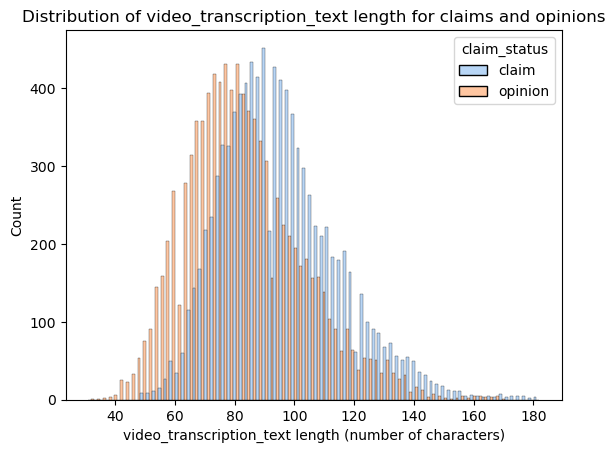

In [10]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters on average as observed in the histogram above.

In [11]:
# Prepare string variables for model development 

data_m = data.copy()
# Drop unnecessary columns
data_m = data_m.drop(['#', 'video_id'], axis=1)
# Encode target variable
data_m['claim_status'] = data_m['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
data_m = pd.get_dummies(data_m,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
data_m.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


# Natural Language Processing - Variables

Since one of the independent variables involves comment text, leveraging NLP could serve as a means to discern between claims and opinions. An effective method to derive numerical features from this text is using a bag-of-words approach such as CountVectorizer. This tool operates by breaking text into n-grams, consecutive word groups.

Once the count matrix is established, CountVectorizer allows the option to retain the most frequent n-grams, a quantity specified by the user. These chosen n-grams can then function as features within a model.

The process of dividing text into n-grams exemplifies tokenization, which involves breaking text into smaller units to extract meaning from these resultant tokens.

After modifed the dataset to remove uncessesary values and encode the other text values we are ready to use the data for model development 

### Data Split 

In [12]:
# Isolate target variable
y = data_m['claim_status']
# Isolate features
data_m = data_m.drop(['claim_status'], axis=1)


In [13]:
data_m.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [14]:
# train/validate/test datasets
## training and testing
X_tr, X_test, y_tr, y_test = train_test_split(data_m, y, test_size=0.2, random_state=0)
## Split training into train and validate datasets 
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)


In [15]:
## Verified correct Splits 
y_val.shape, y_test.shape

((3817,), (3817,))

In [16]:
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()

count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

In [17]:
##Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)

# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)


In [18]:
X_val_final

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,54,986192.0,488152.0,130586.0,12109.0,3436.0,130,False,False,True,...,0,0,1,0,0,0,0,0,0,0
3813,9,78086.0,35655.0,13509.0,445.0,293.0,84,False,False,False,...,0,0,0,0,0,1,0,0,0,0
3814,41,199971.0,117234.0,2104.0,2897.0,1191.0,107,False,False,False,...,0,1,0,0,0,0,0,0,0,0
3815,35,906448.0,565674.0,190444.0,12134.0,608.0,120,False,False,False,...,0,0,0,0,0,0,0,0,0,0


# Model Building

### Random Forest 

In [19]:
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }
# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']  # Changed to a list for scoring metrics

# Instantiate GridSearchCV with the updated parameters
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [27]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
            
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

# Create GridSearchCV object with the specified scoring metrics


# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [28]:
rf_cv.estimator.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [29]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: total: 14min 8s
Wall time: 14min 21s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [30]:
# Examine best recall score
rf_cv.best_score_

0.9953408110440034

In [31]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

##  XGBoost model

In [32]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}
# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [33]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 10min 33s
Wall time: 1min 27s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [34]:
xgb_cv.best_score_

0.9898176171763818

In [35]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

# Evaluate models
## Random Forest

In [36]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

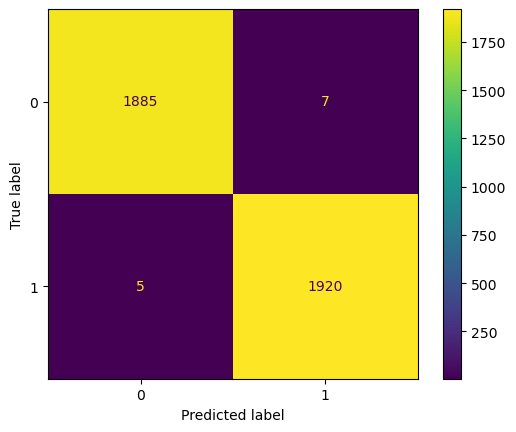

In [38]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [39]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



## XGBoost

In [40]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

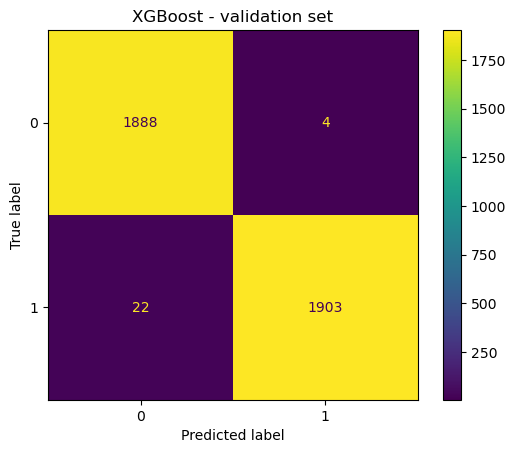

In [41]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [42]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



## Best  model to make predictions on the test dataset.

In [43]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

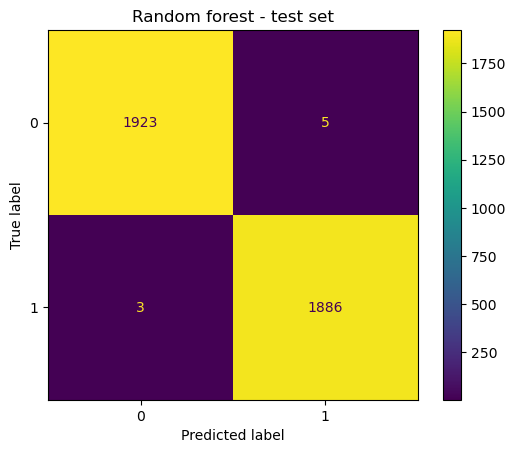

In [44]:
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

### Feature importances of best model

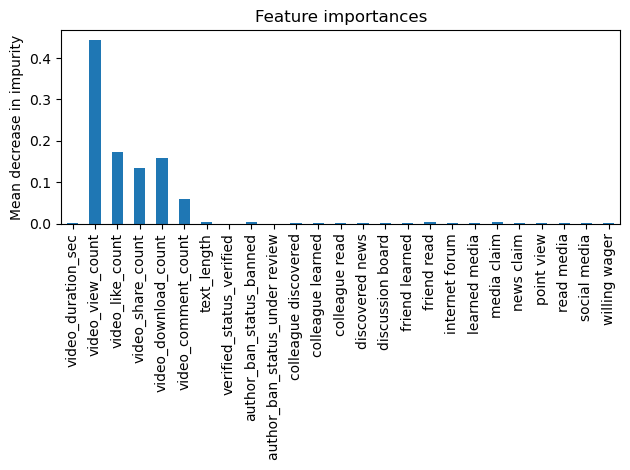

In [45]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

## Conclusion

The selected model has proven its efficacy beyond doubt. With consistently high performance on both the validation and test holdout data, it demonstrates robustness and reliability in distinguishing between factual claims and subjective opinions.

Given its impressive precision and F1 scores across the board, I would strongly advocate for its deployment. The model's reliance on key user engagement metrics, such as views, likes, shares, and downloads, underscores its ability to accurately classify content.

While the current iteration performs admirably, there's always room for improvement. Incorporating additional features, such as data on video reporting frequency and total user reports per author, could further enhance its capabilities.

In conclusion, the selected model stands as a formidable solution for the social media company's content moderation requirements, offering a potent blend of accuracy, efficiency, and potential for refinement